In [1]:
import numpy as np
import matplotlib as mpl
import collections
import copy
from qbstyles import mpl_style
import gym
from gym import spaces
import or_gym
from or_gym.utils.env_config import *
from or_gym.algos.rl_utils import create_env
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
mpl_style(dark=False)

In [345]:
class InvManagementMaster(gym.Env):
    
    def __init__(self, *args, **kwargs):
        
        self.step_limit = 30
        self.initial_inventory = np.array([100, 100, 200])
        self.unit_price = 2                                       # p
        self.unit_cost = np.array([1.5, 1.0, 0.75, 0.5])          # r
        self.backlog_cost = np.array([0.1, 0.075, 0.05, 0.025])   # k
        self.holding_cost = np.array([0.15, 0.1, 0.05])           # h
        self.supply_capacity = np.array([100, 90, 80])            # c
        self.lead_times = np.array([3, 5, 10])                    # L
        self.backlog = True
        self.dist = 1
        self.dist_param = {'mu': 20}
        self.alpha = 0.97
        self.seed_int = 0
        self.user_dist = np.zeros(self.step_limit)
        self.num_stages = len(self.initial_inventory) + 1
        
        distributions = {1: stats.poisson,
                         2: stats.binom,
                         3: stats.randint,
                         4: stats.geom,
                         5: self.user_dist}
        self.demand_dist = distributions[self.dist]
        if self.dist < 5:
            self.seed(self.seed_int)
        
        self.action_space = spaces.Box(
            low=np.zeros(self.num_stages-1), high=self.supply_capacity, dtype=np.int16)
        self.observation_space = spaces.Box(
            low=-np.ones(self.num_stages-1)*self.supply_capacity.max()*self.step_limit,
            high=self.supply_capacity*self.step_limit)
        
        self.reset()
        
    def seed(self, seed=None):
        if seed != None:
            np.random.seed(seed=int(seed))

    def reset(self):
        self.current_step = 0
        self.inventory_levels = np.zeros((self.step_limit, 
            self.num_stages-1), dtype=np.int16)
        self.inventory_in_transit = self.inventory_levels.copy()
        self.backlog_orders = np.zeros((self.step_limit,
            self.num_stages), dtype=np.int16)
        self.retail_demand = np.zeros(self.step_limit)
        self.profits = self.retail_demand.copy()
        self.inventory_levels[0] = self.initial_inventory.copy()
        self.recievables = self.inventory_in_transit.copy()
        self.order_history = np.zeros((self.step_limit, self.num_stages-1))
        self.state = self.initial_inventory.copy()
        return self.state

    def step(self, action):
        action = np.maximum(action, 0).astype(int)
        t = self.current_step
        self.order_history[t] = action.copy()
        current_inventory = self.inventory_levels[t].copy()
        current_backlog = self.backlog_orders[t].copy()
        shipments = np.zeros(self.num_stages)
        # Receive inventory in transit
        for i in range(self.num_stages - 1):
            if t - self.lead_times[i] >= 0:
                current_inventory[i] += self.inventory_in_transit[t - self.lead_times[i], i]
                self.recievables[t, i] += self.inventory_in_transit[t - self.lead_times[i], i]

        # Sell retail demand
        if self.dist < 5:
            retail_demand = self.demand_dist.rvs(**self.dist_param)
        else:
            retail_demand = self.demand_dist[n]
        
        total_demand = current_backlog.copy()
        total_demand[0] += retail_demand
        total_demand[1:] += action
        shipments[-1] = total_demand[-1]
        for i in range(3):
            if current_inventory[i] >= total_demand[i]:
                shipments[i] += total_demand[i]
                current_inventory[i] -= total_demand[i]
                backlog[i] = 0
            else:
                backlog[i] = total_demand[i] - current_inventory[i]
                current_inventory[i] = 0

        reward = np.sum(shipments[0]*env.unit_price - 
            (env.unit_cost*shipments + env.backlog_cost*backlog) \
                + np.sum(env.holding_cost*current_inventory))
        self.inventory_in_transit[t] = shipments[1:].copy()
        
        self.current_step += 1
        
        done = True if self.current_step >= self.step_limit else False
        
        self.state = current_inventory.copy()
        if not done:
            self.inventory_levels[self.current_step] = current_inventory.copy()
            self.backlog_orders[self.current_step] = backlog.copy()
        
        # Log values
        self.retail_demand[t] += retail_demand
        self.profits[t] += reward        
        
        return self.state, reward, done, {
            'retail_demand': retail_demand,
            'shipments': shipments,
            'inventory_in_transit': self.inventory_in_transit.sum(axis=0),
            'backlog': self.backlog_orders.sum(axis=0)}

In [327]:
env = InvManagementMaster()
ep_rewards = []
for i in range(1000):
    s = env.reset()
    R = 0
    done = False
    while done == False:
        valid_obs = env.observation_space.contains(s)
        action = env.action_space.sample()
        valid_action = env.action_space.contains(action)
        s, r, done, _ = env.step(action)
        R += r
        if not valid_obs:
            print("Invalid observation:\t{}".format(s))
        if not valid_action:
            print("Invalid action:\t{}".format(action))
        if done:
            ep_rewards.append(R)

In [328]:
np.mean(ep_rewards), np.min(ep_rewards), np.max(ep_rewards)

(1412.7395, -180.2, 7779.675)

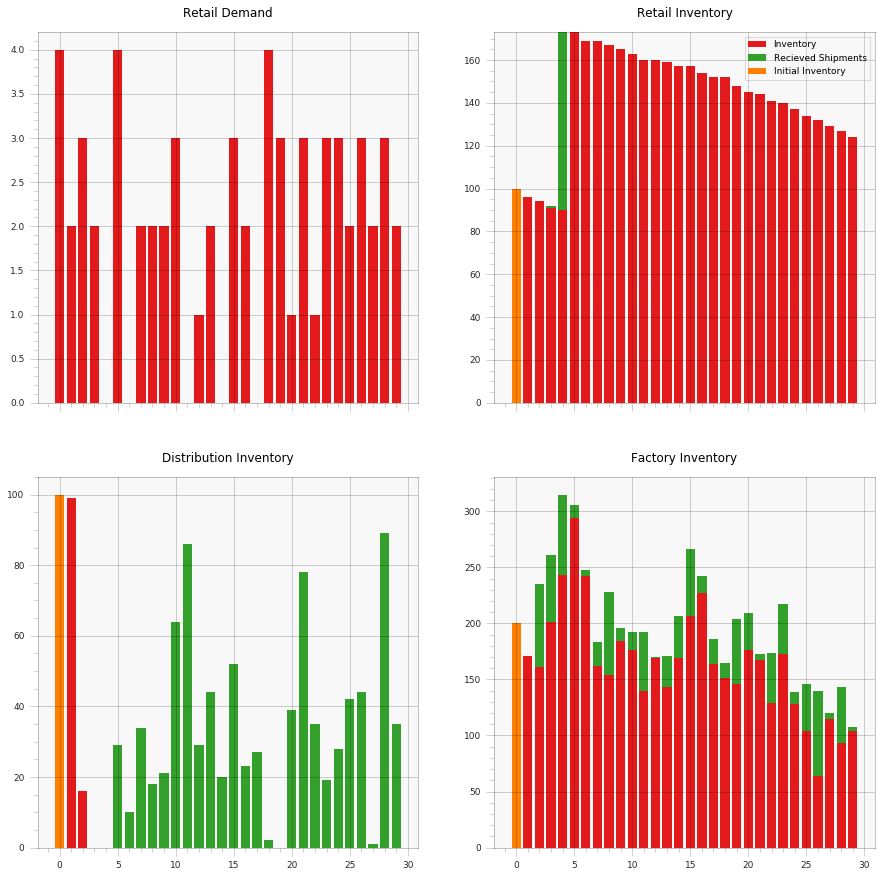

In [329]:
# Plot results
fig, ax = plt.subplots(2, 2, figsize=(15, 15), sharex=True)

ax[0, 0].bar(np.arange(env.step_limit), env.retail_demand)
ax[0, 0].set_title('Retail Demand')

ax[0, 1].bar(np.arange(1, env.step_limit), env.inventory_levels[1:, 0], label='Inventory')
ax[0, 1].bar(np.arange(1, env.step_limit), env.recievables[1:, 0], 
             bottom=env.inventory_levels[1:, 0], label='Recieved Shipments')
ax[0, 1].bar(0, env.initial_inventory[0], label='Initial Inventory')
ax[0, 1].set_title('Retail Inventory')
ax[0, 1].legend(bbox_to_anchor=[1, 1])

ax[1, 0].bar(np.arange(1, env.step_limit), env.inventory_levels[1:, 1], label='Inventory')
ax[1, 0].bar(np.arange(1, env.step_limit), env.recievables[1:, 1], 
             bottom=env.inventory_levels[1:, 1], label='Recieved Shipments')
ax[1, 0].bar(0, env.initial_inventory[1], label='Initial Inventory')
ax[1, 0].set_title('Distribution Inventory')

ax[1, 1].bar(np.arange(1, env.step_limit), env.inventory_levels[1:, 2], label='Inventory')
ax[1, 1].bar(np.arange(1, env.step_limit), env.recievables[1:, 2], 
             bottom=env.inventory_levels[1:, 2], label='Recieved Shipments')
ax[1, 1].bar(0, env.initial_inventory[2], label='Initial Inventory')
ax[1, 1].set_title('Factory Inventory')

plt.show()

# Test with Ray

In [339]:
import ray
from ray.rllib import agents
from copy import deepcopy
import time

In [346]:
def set_config(default_config, config_dict=None):
    config = deepcopy(default_config)
    if type(config_dict) == dict:
        for k in config.keys():
            if k in config_dict.keys():
                if type(config[k]) == dict:
                    for m in config[k].keys():
                        if m in config_dict.keys():
                            config[k][m] = config_dict[m]
                else:
                    config[k] = config_dict[k]
            else:
                continue
                
    return config

def train_agent(algo='a3c', iters=50, config_dict={}):
    if hasattr(agents, algo):
        agent = getattr(agents, algo)
        config = set_config(agent.DEFAULT_CONFIG, config_dict)
        trainer = getattr(agent, algo.upper() + 'Trainer')(config, 
            env=InvManagementMaster)
    else:
        raise AttributeError('No attribute {}'.format(algo))
    t0 = time.time()
    results = []
    for n in range(iters):
        t1 = time.time()
        result = trainer.train()
        t2 = time.time()
#         print(pretty_print(result))
        print(result['info']['learner'])
        results.append(result)
        if (n + 1) % 10 == 0:
            print("Iter:\t{}\tMean Rewards:\t{:.1f}".format(n+1, result['episode_reward_mean']) + 
                  "\tEps per second:\t{:.3f}\tTotal Time (s):\t{:.1f}".format(
                      result['episodes_this_iter']/(t2-t1), t2-t0))
    
    return trainer, results

In [347]:
ray.init(ignore_reinit_error=True)
trainer, results = train_agent()

2020-05-13 18:57:14,590	ERROR worker.py:679 -- Calling ray.init() again after it has already been called.
2020-05-13 18:57:15,077	WARNING util.py:45 -- Install gputil for GPU system monitoring.


{'cur_lr': 9.999999747378752e-05, 'policy_loss': 5688.2866, 'policy_entropy': 17.629715, 'var_gnorm': 22.86766, 'vf_loss': 548634.8, 'model': {}, 'grad_gnorm': 40.0, 'vf_explained_var': 5.364418e-07}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -423.1148, 'policy_entropy': -5.4295564, 'var_gnorm': 23.122725, 'vf_loss': 207021.11, 'model': {}, 'grad_gnorm': 39.999996, 'vf_explained_var': 6.556511e-07}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -21208.031, 'policy_entropy': -35.609386, 'var_gnorm': 23.261333, 'vf_loss': 2682198.8, 'model': {}, 'grad_gnorm': 39.999985, 'vf_explained_var': -9.179115e-06}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -6513.4727, 'policy_entropy': -40.904995, 'var_gnorm': 23.333094, 'vf_loss': 184884.6, 'model': {}, 'grad_gnorm': 40.000004, 'vf_explained_var': 0.0}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -14699.013, 'policy_entropy': -50.027386, 'var_gnorm': 23.393509, 'vf_loss': 552785.5, 'model': {}, 'grad_gnorm': 39.999996, 'vf_expla

{'cur_lr': 9.999999747378752e-05, 'policy_loss': -1378.8674, 'policy_entropy': -22.139868, 'var_gnorm': 31.293526, 'vf_loss': 58178.113, 'model': {}, 'grad_gnorm': 40.0, 'vf_explained_var': 0.29093623}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -33530.547, 'policy_entropy': -58.847324, 'var_gnorm': 31.52854, 'vf_loss': 2722582.2, 'model': {}, 'grad_gnorm': 40.00001, 'vf_explained_var': 0.0015628934}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -775.08765, 'policy_entropy': -26.824049, 'var_gnorm': 31.923378, 'vf_loss': 6975.0103, 'model': {}, 'grad_gnorm': 40.000004, 'vf_explained_var': 0.9070346}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -1333.2714, 'policy_entropy': -16.417896, 'var_gnorm': 32.18422, 'vf_loss': 51776.633, 'model': {}, 'grad_gnorm': 40.0, 'vf_explained_var': 0.4727934}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -33864.793, 'policy_entropy': -64.396706, 'var_gnorm': 32.572083, 'vf_loss': 2576426.2, 'model': {}, 'grad_gnorm': 40.00001, 'vf_explain

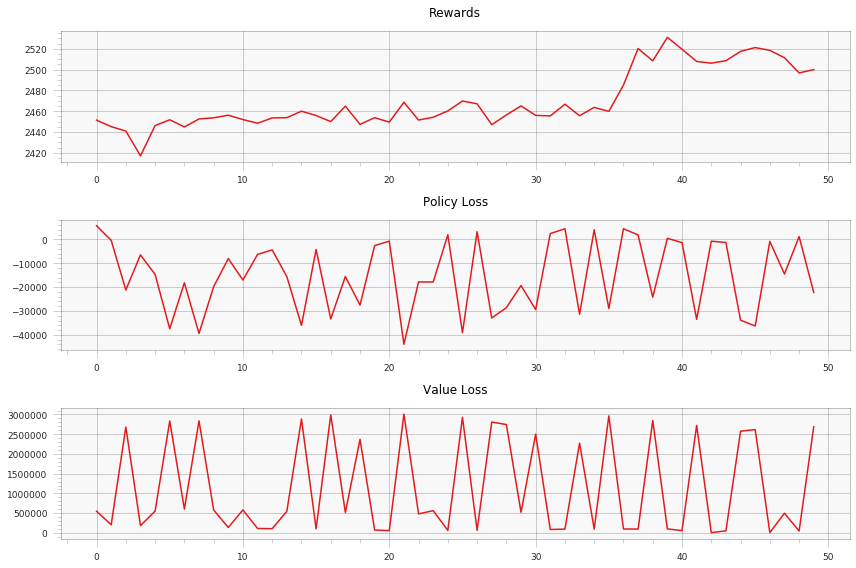

In [350]:
mean_rewards = [i['episode_reward_mean'] for i in results]
policy_loss = [i['info']['learner']['policy_loss'] for i in results]
value_loss = [i['info']['learner']['vf_loss'] for i in results]

fig, ax = plt.subplots(3, 1, figsize=(12,8))
ax[0].plot(mean_rewards)
ax[0].set_title('Rewards')
ax[1].plot(policy_loss)
ax[1].set_title('Policy Loss')
ax[2].plot(value_loss)
ax[2].set_title('Value Loss')
plt.tight_layout()
plt.show()

1


In [91]:
current_inventory[1] = 3

In [41]:
env = InvManagementMaster()

In [19]:
# Build Multi-Echelon Environment
class SupplyChainEnv(gym.Env):
    def __init__(self, config):
        
        self.warehouse_num = 3
        self.demand_history_len = 4
        self.min_obs, self.max_obs = -10000, 10000
        self.T = 26
        self.d_max = 5
        self.d_var = 2
        self.unit_price = 100
        self.unit_cost = 40
        
        self.storage_capacities = np.fromfunction(
            lambda x: 10*(x+1), (self.warehouse_num + 1,), dtype=int)
        self.storage_costs = np.fromfunction(
            lambda x: 2*(x+1), (self.warehouse_num + 1,), dtype=int)
        self.transportation_costs = np.fromfunction(
            lambda x: 5*(x+1), (self.warehouse_num,), dtype=int)
        self.penalty_unit_cost = self.unit_price
                
        self.reset()
        
        self.action_space = spaces.Box(low=0.0, high=20.0, 
            shape=(self.warehouse_num + 1,), 
                                dtype=np.int16)
        self.observation_space = spaces.Box(self.min_obs, self.max_obs, 
            shape=(self.state.shape), dtype=np.float32)
        
        self.state_indices = {
            'factory_stock': 0,
            'warehouse_stock': np.arange(1, self.warehouse_num + 1),
            'demand_history': np.arange(self.warehouse_num + 1, 
                self.warehouse_num *(1 + self.demand_history_len) + 1),
            'timestep': self.warehouse_num * (1 + self.demand_history_len) + 1
        }
        
    def _generate_demand(self, j, t):
        return np.round(self.d_max/2 \
            + self.d_max/2*np.sin(2*np.pi*(t + 2*j) / self.T*2) \
            + np.random.randint(0, self.d_var))
    
    def _initialize_demand(self):
        self.demand_history = collections.deque(maxlen=self.demand_history_len)
        _ = [self.demand_history.append(np.zeros(self.warehouse_num))
             for i in range(self.demand_history_len)]
        
    def generate_demand(self):
        return np.fromfunction(lambda x: 
            self._generate_demand(x+1, self.t), 
            (self.warehouse_num,), dtype=int)
    
    def init_state(self):
        self.t = 0
        self._initialize_demand()
        self.factory_stock = 0
        self.warehouse_stock = np.repeat(
            self.factory_stock, self.warehouse_num)
    
    def get_state(self):
        state = np.concatenate(
            ([self.factory_stock],
              self.warehouse_stock,
              np.hstack(self.demand_history),
             [self.t]))
        return self._check_bounds(state)

    def reset(self):
        self.init_state()
        self.state = self.get_state()
        return self.get_state()
    
    def get_stock_levels(self):
        return np.concatenate(
            ([self.factory_stock], self.warehouse_stock))
    
    def _check_bounds(self, state):
        # Ensure state is within observation bounds
        state = np.where(state<self.min_obs, self.min_obs, state)
        state = np.where(state>self.max_obs, self.max_obs, state)
        return state

    def step(self, action, demand=None):
        if demand is None:
            demand = self.generate_demand()
        
        total_revenue = self.unit_price * demand.sum()
        total_production_cost = self.unit_cost * action[0]
        total_storage_cost = np.dot(self.storage_costs, 
            np.maximum(self.get_stock_levels(),
                np.zeros(self.warehouse_num + 1)))
        total_penalty_cost = -self.penalty_unit_cost * (np.sum(
            np.minimum(self.warehouse_stock, np.zeros(self.warehouse_num))) + \
            np.minimum(self.factory_stock, 0))
        total_transportation_cost = np.dot(self.transportation_costs,
            action[1:])
        reward = total_revenue - total_production_cost - total_storage_cost - \
            total_penalty_cost - total_transportation_cost
        if np.isnan(reward):
            raise ValueError("NaN found in reward.\nState = {}\nReward = {}".format(
                self.state, reward)
                + "\nRev = {}\tProd Cost = {}\tStorage Cost = {}".format(
                    total_revenue, total_production_cost, total_storage_cost)
                + "\nPenalty Cost = {}\tTransportation Cost = {}".format(
                    total_penalty_cost, total_transportation_cost))
        if np.isinf(reward):
            raise ValueError("Inf found in reward.\nState = {}\nReward = {}".format(
                self.state, reward)
                + "\nRev = {}\tProd Cost = {}\tStorage Cost = {}".format(
                    total_revenue, total_production_cost, total_storage_cost)
                + "\nPenalty Cost = {}\tTransportation Cost = {}".format(
                    total_penalty_cost, total_transportation_cost))
        # Update state
        self.factory_stock = min(self.factory_stock + action[0] - np.sum(action[1:]),
            self.storage_capacities[0])
        
        next_state_warehouse_stock = np.zeros(self.warehouse_stock.shape)
        for w in range(self.warehouse_num):
            next_state_warehouse_stock[w] = min(
                self.warehouse_stock[w] + action[w+1] - 
                demand[w], self.storage_capacities[w+1])
        self.warehouse_stock = next_state_warehouse_stock.copy()
        
        self.state = self.get_state()
        self.t += 1
        self.demand_history.append(demand)
        
        return self.state, reward, self.t == self.T - 1, {}

In [20]:
env = SupplyChainEnv({})

In [21]:
from sc_env import SimpleSupplyChain

env1 = SupplyChainEnv({})
env2 = SimpleSupplyChain({})

# Ensure same outputs from different models
env1.reset()
env2.reset()
states, rewards = [], []
detailed_states = []
done = False
count = 0
while done == False:
    action = env2.action_space.sample()
    s2, r2, done2, _ = env2.step(action)
    demand = env2.supply_chain.demand_history[-1].copy()
    s1, r1, done1, _ = env1.step(action, demand)
    states.append(s1==s2)
    detailed_states.append(np.vstack([s1, s2]).T)
    rewards.append(r1==r2)
    count += 1
    if done2 == True:
        break
matching_states = [all(i) for i in states]
print("Rewards match:\t {:.1f}%".format(sum(rewards)/len(rewards)*100))
# print("States match:\t {:.1f}%".format(sum(matching_states)/len(matching_states)*100))
print("States match:\t {:.1f}%".format(sum(sum(states))/(len(states) * len(states[0])) * 100))
print("State Vector Matches (%):\n\t{}".format(sum(states)/len(states)*100))

Rewards match:	 100.0%
States match:	 100.0%
State Vector Matches (%):
	[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100.]


In [12]:
import ray
from ray import tune
from ray.rllib.utils import try_import_tf

import ray.rllib.agents.ddpg as ddpg
from ray.rllib import agents
from ray.tune.logger import pretty_print

In [22]:
tf = try_import_tf()
    
# ray.shutdown()
ray.init(ignore_reinit_error=True)

def train_ddpg():
    config = ddpg.DEFAULT_CONFIG.copy()
    config["log_level"] = "WARN"
    config["actor_hiddens"] = [512, 512] 
    config["critic_hiddens"] = [512, 512]
    config["gamma"] = 0.95
    config["timesteps_per_iteration"] = 1000
    config["target_network_update_freq"] = 5
    config["buffer_size"] = 10000
    
    trainer = ddpg.DDPGTrainer(config=config, env=SupplyChainEnv)
    for i in range(10):
        result = trainer.train()
        print(pretty_print(result))
        checkpoint = trainer.save()
        print("Checkpoint saved at", checkpoint)
    return trainer, result

2020-05-11 18:29:22,683	ERROR worker.py:679 -- Calling ray.init() again after it has already been called.


In [23]:
trainer, result = train_ddpg()

2020-05-11 18:29:23,778	WARNING util.py:45 -- Install gputil for GPU system monitoring.
/home/christian/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/christian/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


custom_metrics: {}
date: 2020-05-11_18-29-25
done: false
episode_len_mean: 25.0
episode_reward_max: -545228.857820034
episode_reward_mean: -545228.857820034
episode_reward_min: -545228.857820034
episodes_this_iter: 1
episodes_total: 1
experiment_id: e72308bfadaf4ce5ad2335f68d334500
hostname: ubuntu
info:
  grad_time_ms: .nan
  learner: {}
  max_exploration: 1.0
  min_exploration: 1.0
  num_steps_sampled: 1000
  num_steps_trained: 0
  num_target_updates: 166
  opt_peak_throughput: 0.0
  opt_samples: .nan
  replay_time_ms: .nan
  sample_time_ms: 1.337
  update_time_ms: 0.001
iterations_since_restore: 1
node_ip: 192.168.0.11
num_healthy_workers: 0
off_policy_estimator: {}
perf:
  cpu_util_percent: 24.666666666666668
  ram_util_percent: 30.600000000000005
pid: 4110
policy_reward_max: {}
policy_reward_mean: {}
policy_reward_min: {}
sampler_perf:
  mean_env_wait_ms: 0.21058124500316577
  mean_inference_ms: 0.7920177071006386
  mean_processing_ms: 0.22159947024716006
time_since_restore: 1.639

custom_metrics: {}
date: 2020-05-11_18-33-41
done: false
episode_len_mean: 25.0
episode_reward_max: -545228.857820034
episode_reward_mean: -545228.857820034
episode_reward_min: -545228.857820034
episodes_this_iter: 0
episodes_total: 1
experiment_id: e72308bfadaf4ce5ad2335f68d334500
hostname: ubuntu
info:
  grad_time_ms: 21.717
  learner:
    default_policy:
      max_q: -5558.4970703125
      mean_q: -14923014.0
      min_q: -27734554.0
  max_exploration: 1.0
  min_exploration: 1.0
  num_steps_sampled: 7000
  num_steps_trained: 1408000
  num_target_updates: 1166
  opt_peak_throughput: 11787.819
  opt_samples: 256.0
  replay_time_ms: 18.314
  sample_time_ms: 2.567
  update_time_ms: 0.002
iterations_since_restore: 7
node_ip: 192.168.0.11
num_healthy_workers: 0
off_policy_estimator: {}
perf:
  cpu_util_percent: 20.441176470588236
  ram_util_percent: 35.76323529411763
pid: 4110
policy_reward_max: {}
policy_reward_mean: {}
policy_reward_min: {}
sampler_perf:
  mean_env_wait_ms: 0.2105812450

In [24]:
import matplotlib.pyplot as plt

In [27]:
def set_config(default_config, config_dict=None):
    config = deepcopy(default_config)
    if type(config_dict) == dict:
        for k in config.keys():
            if k in config_dict.keys():
                if type(config[k]) == dict:
                    for m in config[k].keys():
                        if m in config_dict.keys():
                            config[k][m] = config_dict[m]
                else:
                    config[k] = config_dict[k]
            else:
                continue
                
    return config

def train_agent(algo='a3c', iters=10, config_dict={}):
    if hasattr(agents, algo):
        agent = getattr(agents, algo)
        config = set_config(agent.DEFAULT_CONFIG, config_dict)
        trainer = getattr(agent, algo.upper() + 'Trainer')(config, env=SimpleSupplyChain)
    else:
        raise AttributeError('No attribute {}'.format(algo))
    
    results = []
    for n in range(iters):
        result = trainer.train()
        print(pretty_print(result))
        results.append(result)
    
    return trainer, results

In [28]:
config_dict = {'actor_hiddens': [128, 128],
               'critic_hiddens': [128, 128],
               'timesteps_per_iteration': 1000,
               'buffer_size': 10000}

agent, results = train_agent('a3c', 10, config_dict)

2020-05-11 18:39:01,069	WARNING util.py:45 -- Install gputil for GPU system monitoring.


custom_metrics: {}
date: 2020-05-11_18-39-06
done: false
episode_len_mean: 25.0
episode_reward_max: -174849.06649962068
episode_reward_mean: -209433.55604980726
episode_reward_min: -241399.26977038383
episodes_this_iter: 122
episodes_total: 122
experiment_id: 79c73c02f111446c9251bc70f8b9c292
hostname: ubuntu
info:
  apply_time_ms: 1.45
  dispatch_time_ms: 3.183
  learner:
    cur_lr: 9.999999747378752e-05
    grad_gnorm: 40.0
    model: {}
    policy_entropy: 71.56112670898438
    policy_loss: -1581267.375
    var_gnorm: 22.920698165893555
    vf_explained_var: -0.00012767314910888672
    vf_loss: 2930094080.0
  num_steps_sampled: 3000
  num_steps_trained: 3000
  wait_time_ms: 4.033
iterations_since_restore: 1
node_ip: 192.168.0.11
num_healthy_workers: 2
off_policy_estimator: {}
perf:
  cpu_util_percent: 37.9625
  ram_util_percent: 38.400000000000006
pid: 4110
policy_reward_max: {}
policy_reward_mean: {}
policy_reward_min: {}
sampler_perf:
  mean_env_wait_ms: 0.3796818145304256
  mean_

custom_metrics: {}
date: 2020-05-11_18-39-45
done: false
episode_len_mean: 25.0
episode_reward_max: -158244.16673110425
episode_reward_mean: -605287.0380995265
episode_reward_min: -983646.0
episodes_this_iter: 240
episodes_total: 1882
experiment_id: 79c73c02f111446c9251bc70f8b9c292
hostname: ubuntu
info:
  apply_time_ms: 2.719
  dispatch_time_ms: 6.31
  learner:
    cur_lr: 9.999999747378752e-05
    grad_gnorm: 40.0
    model: {}
    policy_entropy: 419.611328125
    policy_loss: -17398010.0
    var_gnorm: 28.97516632080078
    vf_explained_var: -0.0001055002212524414
    vf_loss: 8876213248.0
  num_steps_sampled: 47000
  num_steps_trained: 47000
  wait_time_ms: 2.643
iterations_since_restore: 8
node_ip: 192.168.0.11
num_healthy_workers: 2
off_policy_estimator: {}
perf:
  cpu_util_percent: 53.35555555555556
  ram_util_percent: 49.28888888888889
pid: 4110
policy_reward_max: {}
policy_reward_mean: {}
policy_reward_min: {}
sampler_perf:
  mean_env_wait_ms: 0.41638333336050953
  mean_infer

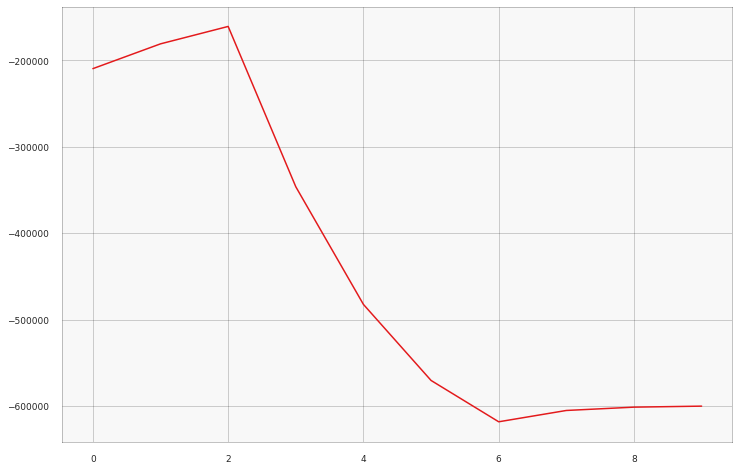

In [30]:
mean_rewards = [i['episode_reward_mean'] for i in results]
plt.figure(figsize=(12,8))
plt.plot(mean_rewards)
plt.show()

In [29]:
results

[{'episode_reward_max': -174849.06649962068,
  'episode_reward_min': -241399.26977038383,
  'episode_reward_mean': -209433.55604980726,
  'episode_len_mean': 25.0,
  'episodes_this_iter': 122,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'sampler_perf': {'mean_env_wait_ms': 0.3796818145304256,
   'mean_processing_ms': 0.2944837185834805,
   'mean_inference_ms': 1.0307402842277567},
  'off_policy_estimator': {},
  'info': {'num_steps_trained': 3000,
   'num_steps_sampled': 3000,
   'wait_time_ms': 4.033,
   'apply_time_ms': 1.45,
   'dispatch_time_ms': 3.183,
   'learner': {'cur_lr': 9.999999747378752e-05,
    'policy_loss': -1581267.4,
    'policy_entropy': 71.56113,
    'var_gnorm': 22.920698,
    'vf_loss': 2930094000.0,
    'model': {},
    'grad_gnorm': 40.0,
    'vf_explained_var': -0.00012767315}},
  'timesteps_this_iter': 3000,
  'done': False,
  'timesteps_total': 3000,
  'episodes_total': 122,
  'training_iteration